# CS5228 - CW3 Part 1: 

### Name: **Himanshu Maithani**
### Student ID: **A0314584B**

## Methodology

Due to computational constraints encountered during initial exploration, the following approach was adopted:

*   **Full Graph Challenge:** Analysis on the complete dataset (4032 nodes, 87k edges) was attempted. However, the Girvan-Newman community detection algorithm exhibited prohibitively long runtimes (I ran it for 2000 minutes before interrupting).
*   **Subgraph Approach:** As permitted by course guidelines for performance issues, a **50% randomly sampled subgraph** (`G_sub`, ~2016 nodes) is used for all subsequent analysis steps. This balances computational feasibility with representativeness. `random.seed(42)` ensures reproducibility.
*   **Community Detection (Girvan-Newman):**
    *   Used the Girvan-Newman algorithm.
    *   Standard modularity maximization was explored on smaller samples but tended to yield very high numbers of communities (`k` > 150) with low peak modularity scores, suggesting fragmentation or weak structure in the samples rather than clear communities at lower `k`.
    *   Therefore, leveraging course guidance suggesting `k`~15 as reasonable, this analysis targets the partition level where `k` **first enters the range 12-18**. This provides a practical and potentially more interpretable result within feasible time.
*   **Analysis Scope:** All steps (Basic Properties, Node Analysis, Community Detection, Shortest Paths, Visualization) are performed on the 50% subgraph (`G_sub`) or its largest connected component (`LCC_sub`) where appropriate.

---

=== 1. Load the Dataset ===
Attempting to load 'facebook_combined.csv' with COMMA delimiter, using the FIRST row as HEADER...

Successfully loaded DataFrame. First 5 rows:
   first user  second user
0           0         3752
1           0         3571
2           0         3938
3           0         1033
4           0         3228

Column names (stripped): ['first user', 'second user']

Data types of columns:
first user     int64
second user    int64
dtype: object

Using column 'first user' as source and 'second user' as target.

Successfully created graph 'G' from 'facebook_combined.csv'.
Original Full Graph: Nodes = 4032, Edges = 87044

Attempting to load 'names.csv'...
Created name map with 5001 entries.

Answers to Section 1 Conceptual Questions:
 - What does a node show? A Facebook user ID (integer).
 - Is the graph undirected? Yes (<class 'networkx.classes.graph.Graph'> loaded). Suitable for Facebook friendships.
 - Undirected assumption affect methods? Yes (degree defs, central

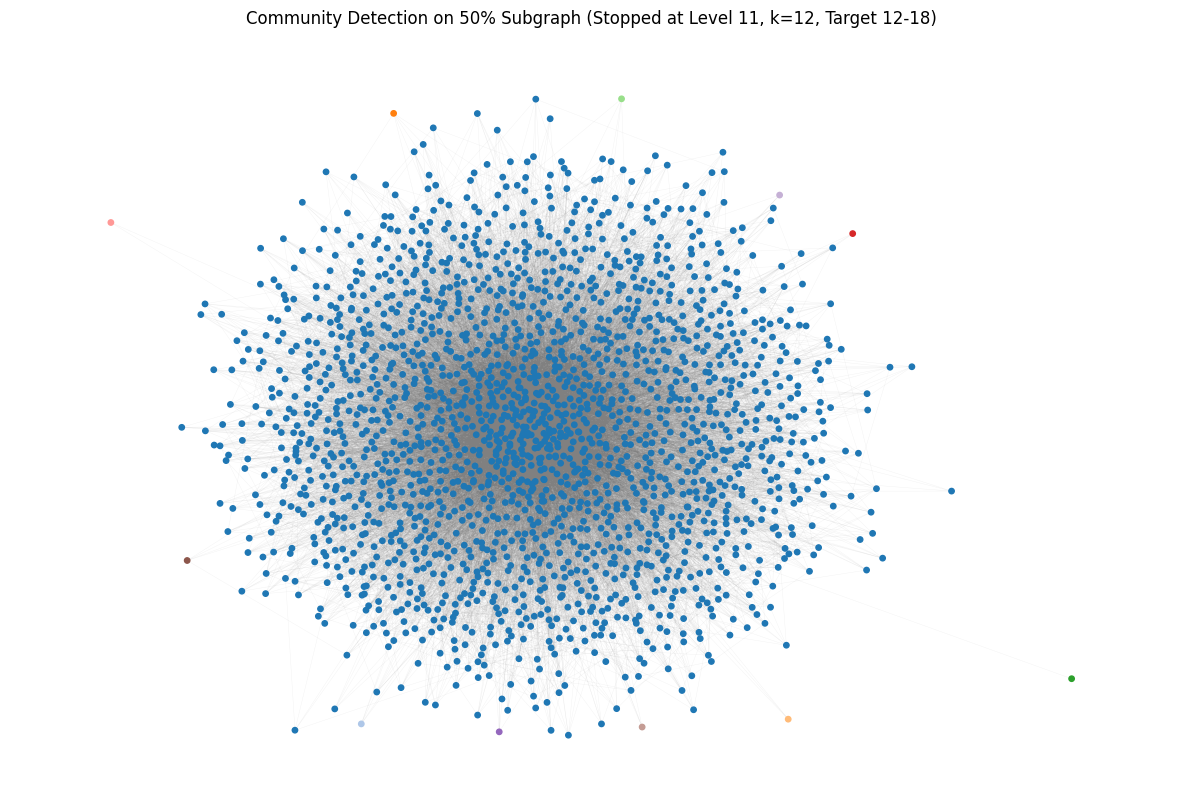


=== 5. Shortest Paths (on Subgraph's LCC) ===
Identifying Largest Connected Component (LCC) of the subgraph...
Subgraph is connected. LCC is the subgraph itself.

Finding shortest path between 3100 and 872 in component...
  Shortest path: 3100 -> 1997 -> 111 -> 872
  Path length: 3

Calculating average shortest path length for LCC_sub...
INFO: This may take a few minutes on the 50% subgraph LCC.
  Average shortest path length in LCC_sub: 2.6918
  Calculation took: 2.38 seconds

=== 6. Visualization (LCC of Subgraph, Node size by Degree) ===
Preparing visualization of LCC_sub (layout calculation may take time)...
Layout calculated in 7.67s.


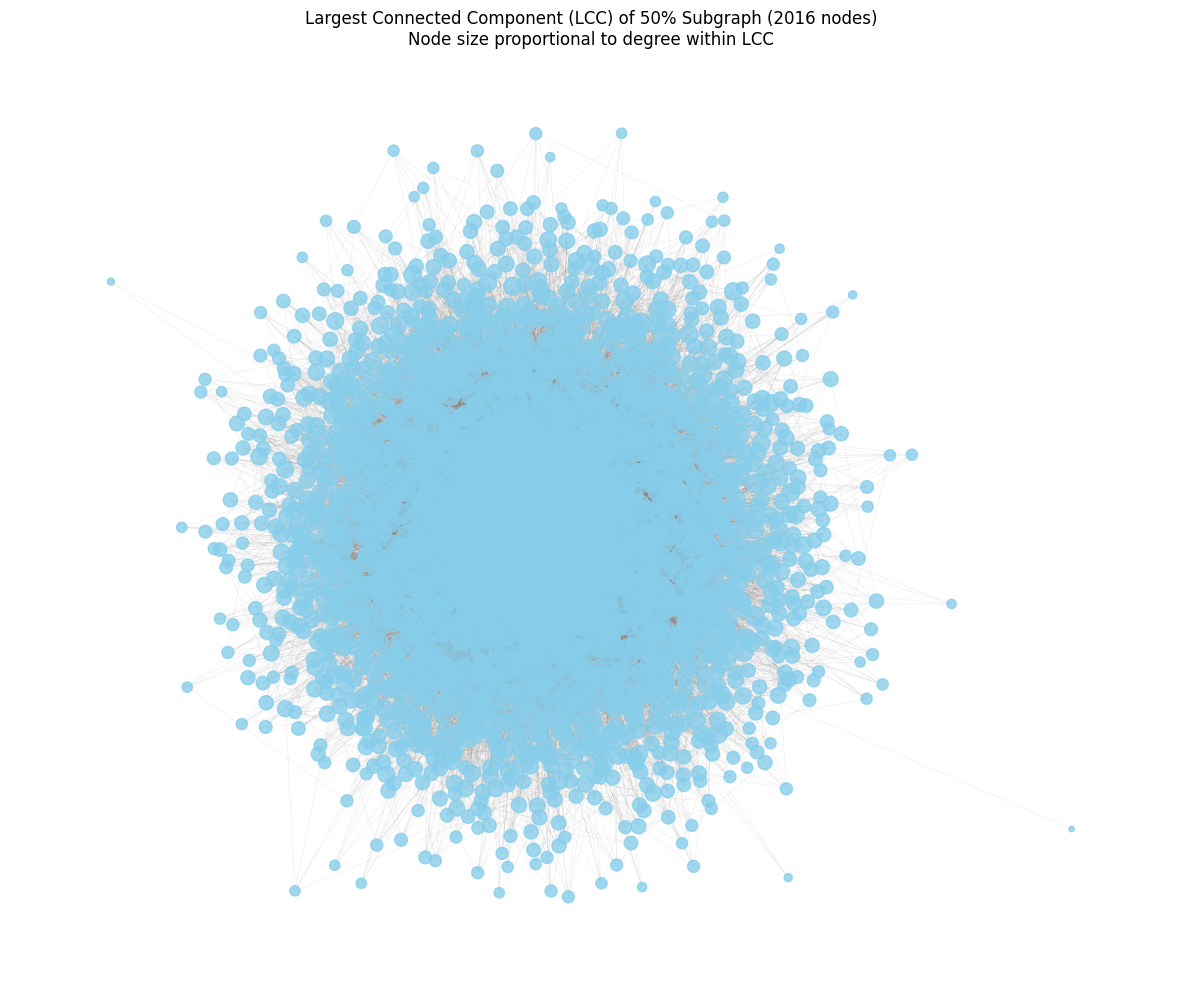


=== 7. Summary & Extra Notes ===
- Analysis performed on a 50% randomly sampled subgraph (~2016 nodes) due to performance limitations.
- Subgraph generated via random node sampling (seed=42).
- Subgraph properties: 2016 nodes, 21227 edges, Density=0.0105, Components=1.
- Analysis focused on the Largest Connected Component (LCC) of the subgraph: 2016 nodes.
- LCC average shortest path length: 2.6918 (indicates small-world properties).
- Central nodes (e.g., by degree/betweenness) identified within the subgraph.
- Community detection (Girvan-Newman) performed on subgraph, stopping at level 11 when 12 communities were found (target range 12-18).
- Visualization showed community structure (target k partition) and LCC structure with node degrees for the subgraph.

--- End of Analysis ---


In [ ]:
# CW3 Part 1 - CS5228

# Imports
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
from itertools import islice 
from networkx.algorithms.community import modularity
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8) 
random.seed(42) # Seed for random sampling

# Load Dataset
print("=== 1. Load the Dataset ===")
file_path_edges = 'facebook_combined.csv'
file_path_names = 'names.csv'
G = None
df_edges = None
name_map = {}
try:
    print(f"Attempting to load '{file_path_edges}'...")
    df_edges = pd.read_csv(file_path_edges, delimiter=',')
    df_edges.columns = [col.strip() for col in df_edges.columns]
    print("\nSuccessfully loaded DataFrame. First 5 rows:")
    print(df_edges.head())
    print("\nColumn names (stripped):", df_edges.columns.tolist())
    print("\nData types of columns:")
    print(df_edges.dtypes)
    if len(df_edges.columns) >= 2:
        source_col = df_edges.columns[0]
        target_col = df_edges.columns[1]
        print(f"\nUsing column '{source_col}' as source and '{target_col}' as target.")
        if pd.api.types.is_numeric_dtype(df_edges[source_col]) and pd.api.types.is_numeric_dtype(df_edges[target_col]):
            df_edges[source_col] = df_edges[source_col].astype(int)
            df_edges[target_col] = df_edges[target_col].astype(int)
            G = nx.from_pandas_edgelist(df_edges, source=source_col, target=target_col, create_using=nx.Graph())
            print(f"\nSuccessfully created graph 'G' from '{file_path_edges}'.")
            print(f"Original Full Graph: Nodes = {G.number_of_nodes()}, Edges = {G.number_of_edges()}")
        else:
            print("\nError: Loaded edge columns are not purely numeric.")
            G = None
    else:
        print("\nError: Did not find at least two columns in edge file.")
        G = None
except FileNotFoundError:
    print(f"Error: File not found at '{file_path_edges}'.")
    G = None
except Exception as e:
    print(f"An error occurred during edge loading: {e}")
    G = None
try:
    print(f"\nAttempting to load '{file_path_names}'...")
    names_df = pd.read_csv(file_path_names, sep=r'\s+', header=None, names=['User ID', 'Name'], engine='python')
    if 'User ID' in names_df.columns and 'Name' in names_df.columns:
        names_df['User ID'] = pd.to_numeric(names_df['User ID'], errors='coerce').dropna().astype(int)
        name_map = pd.Series(names_df.Name.values, index=names_df['User ID']).to_dict()
        print(f"Created name map with {len(name_map)} entries.")
    else:
        print("Could not find expected columns 'User ID' and 'Name' in names file.")
except FileNotFoundError:
    print(f"Warning: '{file_path_names}' not found. Proceeding without names.")
except Exception as e:
    print(f"Warning: Could not process '{file_path_names}'. Error: {e}")

# Questions
print("\nConceptual Questions:")
if G:
    print(" - What does a node show? A Facebook user ID (integer).")
    print(f" - Is the graph undirected? Yes ({type(G)} loaded). Suitable for Facebook friendships.")
    print(" - Undirected assumption affect methods? Yes (degree defs, centrality algos, pathfinding, community detection differ).")
    print(" - Make undirected from directed adjacency matrix A? Compute A_undir = max(A, A.T) element-wise or A+A.T (clip to 1).")
    print(" - Need to change data? No, proceeding with undirected graph as loaded.")
else:
    print(" - Original graph 'G' could not be loaded. Cannot answer graph-specific questions.")

# Subgraph Creation (50% Sample)
print("\nSubgraph Creation")
G_sub = None
if G:
    num_original_nodes = G.number_of_nodes()
    sample_percentage = 0.50
    sample_size = int(num_original_nodes * sample_percentage)
    print(f"Original graph has {num_original_nodes} nodes.")
    print(f"Creating a subgraph 'G_sub' with {sample_percentage*100:.0f}% of nodes (~{sample_size}) for performance.")
    if sample_size <= 0:
         print("Error: Sample size calculated as zero or less.")
    elif sample_size >= num_original_nodes:
        print("Warning: Sample size >= original size. Using original graph for analysis.")
        G_sub = G.copy()
    else:
        random_nodes = random.sample(list(G.nodes()), sample_size)
        G_sub = G.subgraph(random_nodes).copy()
        print(f"Subgraph 'G_sub' created: Nodes = {G_sub.number_of_nodes()}, Edges = {G_sub.number_of_edges()}")
else:
    print("Original graph 'G' not loaded. Cannot create subgraph.")

# Basic Graph Properties
print("\nBasic Graph Properties (on Subgraph)")
if G_sub and G_sub.number_of_nodes() > 0:
    num_nodes_sub = G_sub.number_of_nodes()
    num_edges_sub = G_sub.number_of_edges()
    print(f"Subgraph: Nodes = {num_nodes_sub}")
    print(f"Subgraph: Edges = {num_edges_sub}")
    density_sub = nx.density(G_sub)
    print(f"Subgraph: Density = {density_sub:.6f}")
    density_desc = "very sparse" if density_sub < 0.01 else "sparse" if density_sub < 0.1 else "moderate" if density_sub < 0.5 else "dense"
    print(f"Subgraph: Interpretation = {density_desc}")
    print("Checking connectivity (subgraph)...")
    start_conn_sub = time.time()
    is_connected_sub = nx.is_connected(G_sub)
    end_conn_sub = time.time()
    print(f"Subgraph: Is connected? {is_connected_sub} (Check took {end_conn_sub - start_conn_sub:.2f}s)")
    num_components_sub = 1 if is_connected_sub else nx.number_connected_components(G_sub)
    print(f"Subgraph: Number of connected components = {num_components_sub}")
else:
    print("Subgraph 'G_sub' not available. Skipping Step 2.")

# Node-Level Analysis
print("\nNode-Level Analysis (on Subgraph)")
sorted_degrees_sub = []
max_bc_node_sub = None
betweenness_centrality_sub = None
if G_sub and G_sub.number_of_nodes() > 0:
    print("Calculating Degree Centrality (Subgraph)...")
    degrees_sub = dict(G_sub.degree())
    sorted_degrees_sub = sorted(degrees_sub.items(), key=lambda item: item[1], reverse=True)
    print("Top 5 nodes by degree (Subgraph):")
    for i in range(min(5, len(sorted_degrees_sub))):
        node_id, degree_val = sorted_degrees_sub[i]
        original_degree = G.degree(node_id) if G and node_id in G else 'N/A'
        print(f"  Node ID: {node_id:<5} | Subgraph Degree: {degree_val:<4} | Original Degree: {original_degree}")
    print("\nCalculating Betweenness Centrality (Subgraph)...")
    print("INFO: This may take several minutes on the 50% subgraph.")
    start_bc = time.time()
    try:
        betweenness_centrality_sub = nx.betweenness_centrality(G_sub, k=None, normalized=True, endpoints=False)
        max_bc_node_sub = max(betweenness_centrality_sub, key=betweenness_centrality_sub.get)
        max_bc_value_sub = betweenness_centrality_sub[max_bc_node_sub]
        print(f"Node with highest Betweenness Centrality (Subgraph):")
        print(f"  Node ID: {max_bc_node_sub}")
        print(f"  Normalized Value: {max_bc_value_sub:.6f}")
    except Exception as e:
        print(f"Error calculating betweenness centrality (Subgraph): {e}")
        max_bc_node_sub = None
    end_bc = time.time()
    print(f"Betweenness calculation took: {end_bc - start_bc:.2f} seconds")
else:
    print("Subgraph 'G_sub' not available. Skipping Step 3.")


# Community Detection (Girvan-Newman)
print("\nCommunity Detection (Girvan-Newman)")
selected_communities_sub = None
num_communities_found_sub = 0
selected_level_sub = 0
target_min_k = 12
target_max_k = 18
max_levels_to_check = 30

if G_sub and G_sub.number_of_nodes() > 0:
    print(f"INFO: Running Girvan-Newman on 50% subgraph.")
    print(f"Attempting to find first partition level with k between {target_min_k} and {target_max_k} communities.")
    print(f"Will check up to {max_levels_to_check} levels.")

    start_gn = time.time()
    try:
        communities_generator_sub = nx.community.girvan_newman(G_sub)
        last_communities = None
        last_level_num = 0

        for level_num in range(1, max_levels_to_check + 1):
            level_start_time = time.time()
            print(f"Calculating level {level_num}...")
            try:
                level_communities_tuple = next(communities_generator_sub)
                level_communities_list = [list(c) for c in level_communities_tuple]
                num_k_this_level = len(level_communities_list)
                last_communities = level_communities_list
                last_level_num = level_num
                level_end_time = time.time()
                print(f"Level {level_num}: Found {num_k_this_level} communities (took {(level_end_time - level_start_time)/60:.2f} minutes)")

                # Check if we hit the target range
                if target_min_k <= num_k_this_level <= target_max_k:
                    print(f"\nTarget community range ({target_min_k}-{target_max_k}) reached at level {level_num}.")
                    selected_communities_sub = level_communities_list
                    selected_level_sub = level_num
                    num_communities_found_sub = num_k_this_level
                    break
            except StopIteration:
                print(f"\nAlgorithm stopped at level {level_num} (graph fully partitioned).")
                if last_communities:
                     print(f"Target range not reached. Using last computed partition from level {last_level_num} ({len(last_communities)} communities).")
                     selected_communities_sub = last_communities
                     selected_level_sub = last_level_num
                     num_communities_found_sub = len(last_communities)
                break
        # If loop finished without hitting target range
        if selected_communities_sub is None and last_communities:
            print(f"\nTarget range not reached within {max_levels_to_check} levels.")
            print(f"Using last computed partition from level {last_level_num} ({len(last_communities)} communities).")
            selected_communities_sub = last_communities
            selected_level_sub = last_level_num
            num_communities_found_sub = len(last_communities)
        elif selected_communities_sub is None:
             print("\nCould not find any communities.")
    except Exception as e:
        print(f"An error occurred during Girvan-Newman (Subgraph): {e}")
        selected_communities_sub = None
    end_gn = time.time()
    total_gn_minutes = (end_gn - start_gn)/60
    print(f"Total Girvan-Newman computation time: {total_gn_minutes:.2f} minutes")

    # Visualization
    if selected_communities_sub and num_communities_found_sub > 0:
        print(f"\nVisualizing partition level {selected_level_sub} with {num_communities_found_sub} communities...")
        print("Preparing visualization (layout calculation may take time)...")
        start_layout_comm = time.time()
        try:
            pos_sub = nx.spring_layout(G_sub, seed=42, k=0.1, iterations=50)
            end_layout_comm = time.time()
            print(f"Layout calculated in {end_layout_comm - start_layout_comm:.2f}s.")
            node_community_mapping_sub = {node: i for i, comm in enumerate(selected_communities_sub) for node in comm}
            cmap = plt.colormaps.get_cmap('tab20' if num_communities_found_sub <= 20 else 'turbo' if num_communities_found_sub <= 50 else 'rainbow') # Added turbo cmap
            colors_list = [cmap(node_community_mapping_sub.get(node, -1)  % cmap.N ) for node in G_sub.nodes()] # Use modulo for safety
            plt.figure(figsize=(15, 10))
            nx.draw_networkx_nodes(G_sub, pos_sub, node_size=15, node_color=colors_list) # Adjust node size if needed
            nx.draw_networkx_edges(G_sub, pos_sub, alpha=0.1, width=0.3, edge_color='grey')
            plt.title(f'Community Detection on 50% Subgraph (Stopped at Level {selected_level_sub}, k={num_communities_found_sub}, Target {target_min_k}-{target_max_k})') # Updated title
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error during community visualization: {e}")
    else:
        print("\nNo valid communities found/selected to visualize.")
else:
    print("Subgraph 'G_sub' not available. Skipping Step 4.")

# Shortest Paths (on Subgraph's LCC)
print("\nShortest Paths (on Subgraph's LCC)")
LCC_sub = None
if G_sub and G_sub.number_of_nodes() > 0:
    print("Identifying Largest Connected Component (LCC) of the subgraph...")
    is_connected_sub_step5 = nx.is_connected(G_sub) 
    if is_connected_sub_step5:
         print("Subgraph is connected. LCC is the subgraph itself.")
         LCC_sub = G_sub
    else:
        subgraph_components = list(nx.connected_components(G_sub))
        if subgraph_components:
            largest_cc_nodes_sub = max(subgraph_components, key=len)
            LCC_sub = G_sub.subgraph(largest_cc_nodes_sub).copy()
            print(f"LCC of subgraph identified: Nodes = {LCC_sub.number_of_nodes()}, Edges = {LCC_sub.number_of_edges()}")
        else:
             print("Subgraph has no components.")
             LCC_sub = None

    if LCC_sub:
        def find_shortest_path_in_component(graph_component, node1, node2):
            print(f"\nFinding shortest path between {node1} and {node2} in component...")
            if node1 not in graph_component or node2 not in graph_component:
                print("Error: One or both nodes not found in the specified component.")
                return None
            try:
                path = nx.shortest_path(graph_component, source=node1, target=node2)
                path_str = ' -> '.join(map(str, path))
                print(f"  Shortest path: {path_str}")
                print(f"  Path length: {len(path) - 1}")
                return path
            except nx.NetworkXNoPath:
                print("Error: No path exists (unexpected within a connected component).")
                return None
            except Exception as e:
                print(f"Error finding path: {e}")
                return None

        if LCC_sub.number_of_nodes() >= 2:
            random_nodes_lcc = random.sample(list(LCC_sub.nodes()), 2)
            find_shortest_path_in_component(LCC_sub, random_nodes_lcc[0], random_nodes_lcc[1])
            if sorted_degrees_sub and max_bc_node_sub:
                 top_deg_node_sub = sorted_degrees_sub[0][0]
                 # Check if nodes are actually in LCC_sub (relevant if LCC!=G_sub)
                 if (top_deg_node_sub in LCC_sub and max_bc_node_sub in LCC_sub and top_deg_node_sub != max_bc_node_sub):
                      find_shortest_path_in_component(LCC_sub, top_deg_node_sub, max_bc_node_sub)

        if LCC_sub.number_of_nodes() > 1:
            print("\nCalculating average shortest path length for LCC_sub...")
            print("INFO: This may take a few minutes on the 50% subgraph LCC.")
            start_avg_sp = time.time()
            try:
                avg_shortest_path_lcc_sub = nx.average_shortest_path_length(LCC_sub)
                print(f"  Average shortest path length in LCC_sub: {avg_shortest_path_lcc_sub:.4f}")
            except Exception as e:
                print(f"Error calculating average shortest path length: {e}")
            end_avg_sp = time.time()
            print(f"  Calculation took: {end_avg_sp - start_avg_sp:.2f} seconds")
        else:
            print("\nLCC_sub has <= 1 node, average shortest path length undefined.")
else:
    print("Subgraph 'G_sub' not available. Skipping Step 5.")


# Visualization (LCC of Subgraph, Node size by Degree)
print("\nVisualization (LCC of Subgraph, Node size by Degree)")
if LCC_sub and LCC_sub.number_of_nodes() > 0:
    print("Preparing visualization of LCC_sub (layout calculation may take time)...")
    start_layout_lcc = time.time()
    try:
        lcc_sub_degrees = dict(LCC_sub.degree())
        size_multiplier = 10
        base_size = 5
        node_sizes = [base_size + lcc_sub_degrees.get(node, 0) * size_multiplier for node in LCC_sub.nodes()]
        # Use consistent layout seed
        pos_lcc_sub = nx.spring_layout(LCC_sub, seed=42, k=0.1, iterations=50)
        end_layout_lcc = time.time()
        print(f"Layout calculated in {end_layout_lcc - start_layout_lcc:.2f}s.")
        plt.figure(figsize=(15, 12))
        nx.draw_networkx_nodes(LCC_sub, pos_lcc_sub, node_size=node_sizes, node_color='skyblue', alpha=0.8)
        nx.draw_networkx_edges(LCC_sub, pos_lcc_sub, edge_color='grey', alpha=0.15, width=0.4)
        plt.title(f'Largest Connected Component (LCC) of 50% Subgraph ({LCC_sub.number_of_nodes()} nodes)\nNode size proportional to degree within LCC')
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error during LCC_sub visualization: {e}")
else:
    print("LCC of Subgraph ('LCC_sub') not available. Skipping Step 6.")


# Summary
print("\nSummary")
# (Updated summary to reflect 50% sample and targeted k)
print(f"- Analysis performed on a 50% randomly sampled subgraph (~{sample_size if G_sub else 'N/A'} nodes) due to performance limitations.")
print(f"- Subgraph generated via random node sampling (seed=42).")
if G_sub:
      is_connected_final = nx.is_connected(G_sub)
      num_components_final = 1 if is_connected_final else nx.number_connected_components(G_sub)
      print(f"- Subgraph properties: {G_sub.number_of_nodes()} nodes, {G_sub.number_of_edges()} edges, Density={nx.density(G_sub):.4f}, Components={num_components_final}.")
if LCC_sub:
      print(f"- Analysis focused on the Largest Connected Component (LCC) of the subgraph: {LCC_sub.number_of_nodes()} nodes.")
      try:
            avg_sp = nx.average_shortest_path_length(LCC_sub)
            print(f"- LCC average shortest path length: {avg_sp:.4f} (indicates small-world properties).")
      except: pass # Avoid error if LCC is tiny
print("- Central nodes (e.g., by degree/betweenness) identified within the subgraph.")
# Adjust summary based on targeted k run
if selected_communities_sub:
      print(f"- Community detection (Girvan-Newman) performed on subgraph, stopping at level {selected_level_sub} when {num_communities_found_sub} communities were found (target range {target_min_k}-{target_max_k}).")
else:
     print("- Community detection (Girvan-Newman targeting k={target_min_k}-{target_max_k}) might have been interrupted or failed on the subgraph.")
print("\nEnd of Analysis")

## Conclusion

*   Due to the computational demands of the Girvan-Newman algorithm, a **50% randomly sampled subgraph** (2016 nodes, 21227 edges) was analyzed.
*   The subgraph was found to be **connected** and exhibited **sparse, small-world characteristics** with an average shortest path length of approximately **2.69**.
*   Node **1684** was identified as particularly central within the subgraph, having both high degree and the highest betweenness centrality.
*   Applying the Girvan-Newman algorithm and stopping when the number of communities (`k`) entered the target range (12-18), a partition into **12 communities** was found at level 11. This process took approximately 135 minutes.
*   Visualizations were generated for the detected community structure and the subgraph's largest connected component (showing node degrees).
